In [1]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
# Load environment variables
load_dotenv()

DB_USERNAME = os.getenv('DB_USERNAME')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')

In [3]:
# Create SQL engine
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

# Define query
query = 'SELECT * FROM stock_data;'

# Load data from SQL
df = pd.read_sql(query, engine, index_col='Date')

# Visualise first few rows
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close Lag,Volume Lag,50-Day SMA,200-Day SMA,RSI,MACD,ATR,OBV
Date,,,,,,,,,,,,,,,
2020-08-26 04:00:00+00:00,123.173239,123.966377,122.101888,123.507576,163022400,0.0,0.0,121.850540,211495600.0,99.112378,77.831353,79.615764,6.898723,3.081114,2147447600
2020-08-27 04:00:00+00:00,124.112812,124.447149,120.881681,122.031128,155552400,0.0,0.0,123.507576,163022400.0,99.840029,78.123761,75.127363,6.854619,3.115711,1991895200
2020-08-28 04:00:00+00:00,123.009731,123.429484,121.608928,121.833450,187630000,0.0,0.0,122.031128,155552400.0,100.563045,78.415471,74.521605,6.726180,3.023200,1804265200
2020-08-31 04:00:00+00:00,124.539894,127.878397,122.997542,125.965096,225702700,0.0,4.0,121.833450,187630000.0,101.378487,78.724798,78.435356,6.878490,3.239039,2029967900
2020-09-01 04:00:00+00:00,129.596429,131.587826,127.419572,130.982590,151948100,0.0,0.0,125.965096,225702700.0,102.249699,79.061430,82.042859,7.319690,3.409303,2181916000


In [4]:
# Align 'Close' price with features
df['Close'] = df['Close'].shift(-1) 

# Drop NaN values
df.dropna(inplace=True)

In [5]:
# Define features and target
X = df[['Close Lag', 'Volume Lag', '50-Day SMA', '200-Day SMA', 'RSI', 'MACD', 'ATR', 'OBV']]
y = df[['Close']]

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
# Scale data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [8]:
# Define time steps
time_steps = 60

def create_sequences(X, y, time_steps):
    X_seq = np.array([X[i - time_steps:i] for i in range(time_steps, len(X))])
    y_seq = np.array(y[time_steps:])
    
    return X_seq, y_seq

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

In [10]:
# Build LSTM model
model = Sequential()
model.add(Input(shape=(60, X_train_seq.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
    
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
history = model.fit(
        X_train_seq,
        y_train_seq,
        batch_size=32,
        epochs=50,
        validation_split=0.2,
    )

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0917 - val_loss: 0.0782
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0162 - val_loss: 0.0095
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080 - val_loss: 0.0043
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0073 - val_loss: 0.0034
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066 - val_loss: 0.0038
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0

In [12]:
predictions = scaler_y.inverse_transform(model.predict(X_test_seq))
y_actual = scaler_y.inverse_transform(y_test_seq)

mse = mean_squared_error(y_actual, predictions)
rmse = root_mean_squared_error(y_actual, predictions)
mae = mean_absolute_error(y_actual, predictions)
mape = mean_absolute_percentage_error(y_actual, predictions)
    
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Mean Squared Error (MSE): 271.34380764425214
Root Mean Squared Error (RMSE): 16.472516736802916
Mean Absolute Error (MAE): 15.022051259091025
Mean Absolute Percentage Error (MAPE): 0.06955749255907161


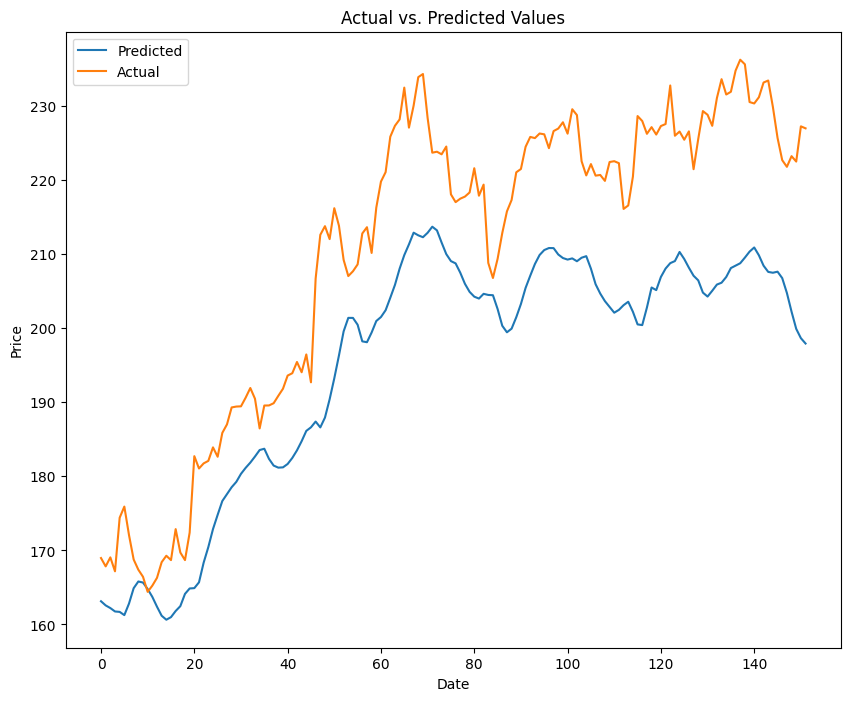

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(predictions, label='Predicted')
plt.plot(y_actual, label='Actual')
plt.title('Actual vs. Predicted Values')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
def get_latest_sequence(scaled_data, time_steps=60):
    latest_sequence = scaled_data[-time_steps:]
    return latest_sequence.reshape((1, time_steps, scaled_data.shape[1]))

def predict_tomorrow_price(model, scaler_X, scaler_y, data, time_steps=60):
    latest_features = data[['Close Lag', 'Volume Lag', '50-Day SMA', '200-Day SMA', 'RSI', 'MACD', 'ATR', 'OBV']]
    latest_features_scaled = scaler_X.transform(latest_features)
    input_sequence = get_latest_sequence(X_test_scaled, time_steps)
    predicted_scaled = model.predict(input_sequence)
    predicted_price = scaler_y.inverse_transform(predicted_scaled)
    return predicted_price[0][0]

latest_data = df.tail(1)

tomorrow_price = predict_tomorrow_price(model, scaler_X, scaler_y, latest_data, time_steps)
print(f"Predicted Tomorrow's Close Price: {tomorrow_price:.2f}")